# Lab 3: 나의 꿈의 여행지 찾기



**도구를 사용하여 LangGraph로 여행 플래너 만들기**



## 개요



이 실습에서는 여행지를 찾기 위한 도구에 접근할 수 있는 에이전트를 만들 것입니다. 이 에이전트에게 질문을 하고, 필요한 도구를 호출하는 것을 지켜보며, 대화를 나눌 수 있습니다. 이 실습은 다음과 같은 시나리오를 다룹니다:



#### 이 실습에서 다루는 내용: 

아래의 측면들을 다룰 것입니다:

- 단일 에이전트 구성

- 에이전트 워크플로우에 `RAG` 추가

- 에이전트의 유형

- `Human-In-The-loop` 개념 소개

- `멀티모달` 에이전트 채팅



## 사용 사례 세부 정보

이 에이전트는 다음 최고의 여행지를 찾는 것을 돕는 여행 챗봇입니다. 사용자의 프로필과 유사한 사용자들의 여행 이력을 기반으로 휴가 목적지를 찾을 수 있는 에이전트를 만들 것입니다. 이 에이전트는 사용할 수 있는 여행 이력 데이터를 기반으로 검색할 수 있는 도구에 접근할 수 있습니다. 우리는 벡터 데이터베이스를 사용하여 유사한 목적지를 생성할 수 있습니다.



1. **초기 사용자 입력**: 

   - 사용자가 여행 추천을 요청

   - 도구는 이미 유사한 여행자 프로필과 매칭하기 위한 `user_id`를 가지고 있음

  

2. **추천된 위치에 대한 추가 세부 정보 제공**:

   - RAG 도구를 사용하여 추천된 위치에 대한 추가 세부 정보 제공

  

3. **Human in the loop**:

   - 사용자 승인을 기반으로 한 도구 실행 시연



### 아래 다이어그램을 통해 이해할 수 있는 2가지 접근 방식이 있습니다. 



- **접근 방식 1**은 어떤 도구를 호출할지 결정할 수 있는 자율 에이전트(`Planners`라고 함)와 최종 답변을 얻을 때까지 도구를 실행(`Solvers`라고 함)할 수 있는 에이전트입니다. 

- **접근 방식 2**는 에이전트가 다음 단계의 순서를 결정하지만 도구가 실행되기 전에 승인 과정을 추가하는 방식입니다.



우리는 또한 2가지 주요 에이전트 구성인 `ReWoO와 ReACT` 에이전트에 대해 간단히 살펴볼 것입니다.



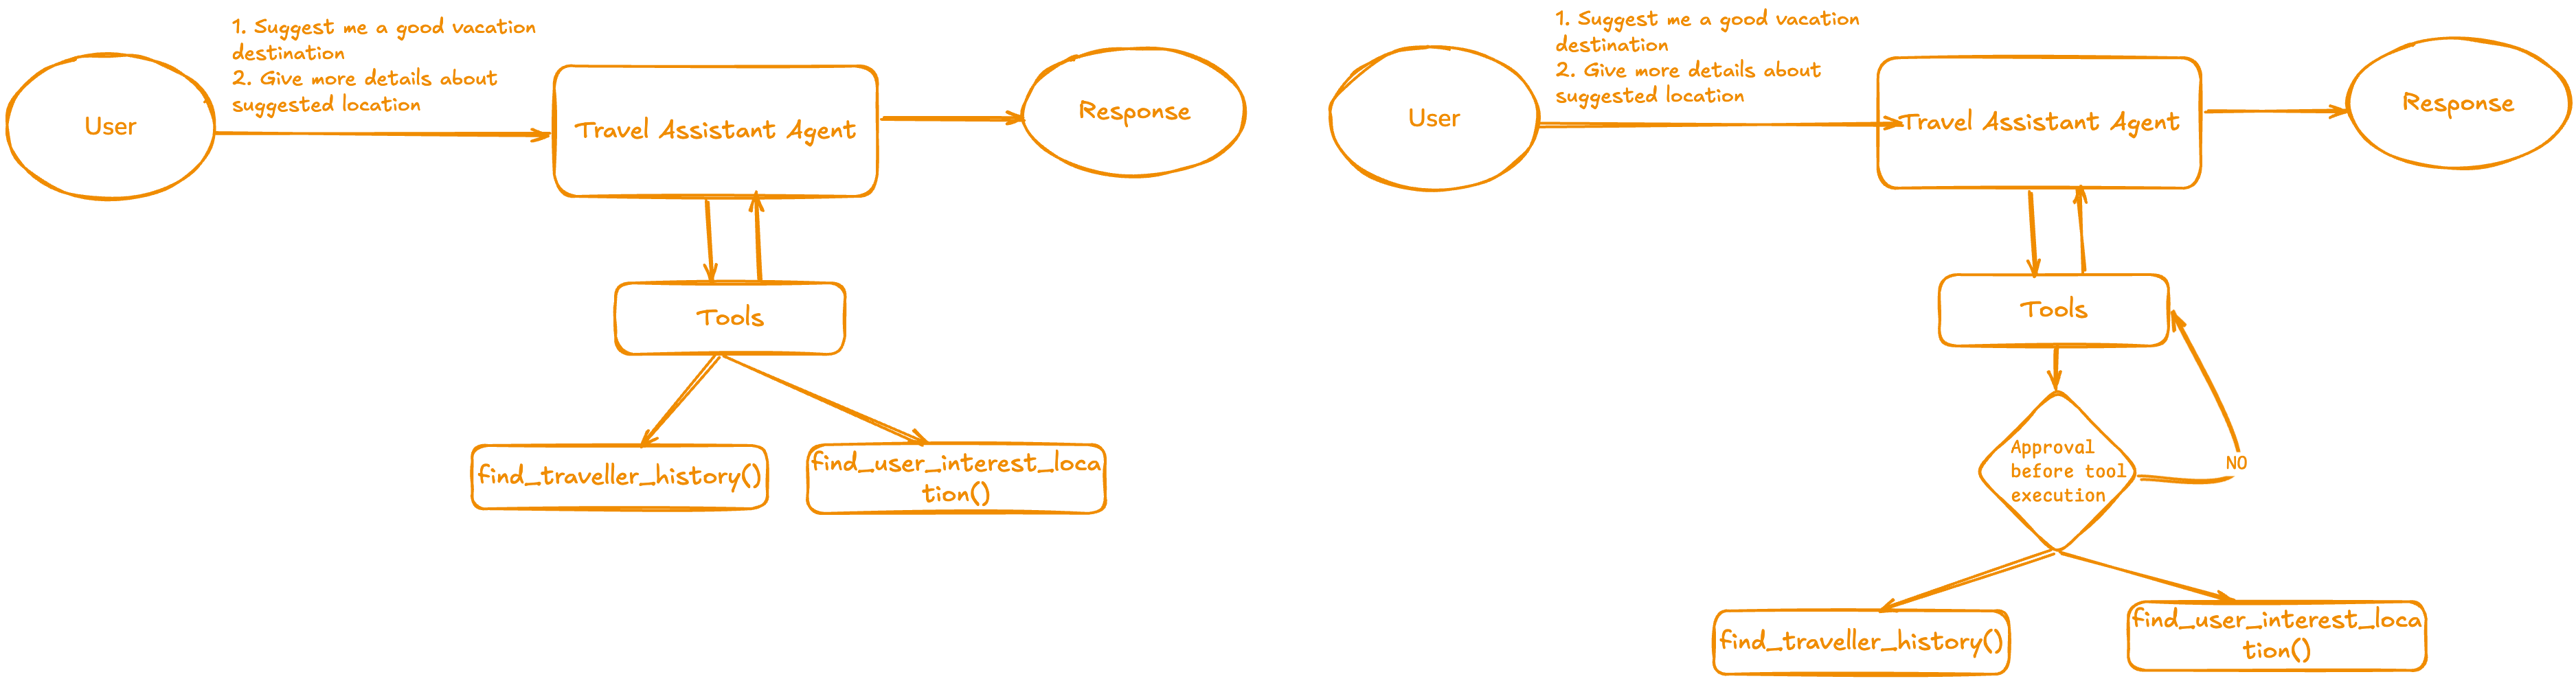

## 설정



필요한 패키지 설치부터 시작하겠습니다.

In [ ]:
# %pip install -U --no-cache-dir  \
# "langchain==0.3.7" \
# "langchain-aws==0.2.6" \
# "langchain-community==0.3.5" \
# "langchain-text-splitters==0.3.2" \
# "langchainhub==0.1.20" \
# "langgraph==0.2.45" \
# "langgraph-checkpoint==2.0.2" \
# "langgraph-sdk==0.1.35" \
# "langsmith==0.1.140" \
# "pypdf==3.8,<4" \
# "ipywidgets>=7,<8" \
# "matplotlib==3.9.0" \
# "faiss-cpu==1.8.0" \
# "pandas==2.2.3"

### 에이전트



AI 에이전트는 특정 목표를 달성하기 위해 인공지능 기술을 사용하여 환경을 인식하고, 결정을 내리며, 행동을 취하는 소프트웨어 프로그램 또는 시스템입니다. 이러한 에이전트들은 어느 정도의 자율성을 가지고 작동하도록 설계되었으며, 경험과 받은 정보를 바탕으로 행동을 조정할 수 있습니다. 그들의 능력은 단순한 상호작용을 넘어서서 인간의 개입 여부와 관계없이 복잡한 의사결정, 문제 해결, 작업 실행에 참여할 수 있습니다.



**AI 에이전트의 주요 특징은 다음과 같습니다:**



**인식:** 센서나 데이터 입력을 통해 환경으로부터 정보를 수집하는 능력.

**의사결정:** AI 알고리즘을 사용하여 정보를 처리하고 최선의 행동 방침을 결정.

**행동:** 결정을 실행하고 환경이나 사용자와 상호작용하는 능력.

**학습:** 경험과 피드백을 통해 시간이 지남에 따라 성능을 향상시키는 능력.

**자율성:** 지속적인 인간의 개입 없이 어느 정도 독립적으로 작동.

**목표 지향:** 특정 목표나 작업을 향해 작업.





LLM은 분류 문제에 탁월하며 이는 `에이전트`가 현실이 되도록 했습니다.

In [ ]:
from langchain_aws import ChatBedrock
import boto3

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")

## 언어 모델



이 실습에서 우리의 모든 에이전트 구현을 지원하는 LLM은 Amazon Bedrock을 통한 Claude 3 Sonnet입니다. 모델에 쉽게 접근하기 위해 우리는 Bedrock의 Converse API의 래퍼인 LangChain의 `ChatBedrockConverse` 클래스를 사용할 것입니다.

In [ ]:
from langchain_aws import ChatBedrockConverse



llm = ChatBedrockConverse(
    model = "us.amazon.nova-lite-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

# 첫 번째 여행 추천 에이전트 만들기

## 도구



사용자의 프로필과 유사한 사용자들의 여행 이력을 기반으로 휴가 목적지를 찾는 데 사용될 도구들을 만들어 보겠습니다.



도구는 LLM 에이전트가 접근하고 활용할 수 있는 외부 리소스, 서비스 또는 API입니다. 이러한 보조 구성 요소들은 에이전트가 핵심 언어 처리 능력을 넘어서서 외부 시스템과 상호작용하고, 정보를 검색하거나, 그렇지 않으면 범위를 벗어나는 작업을 실행할 수 있게 합니다. 도구를 통합함으로써 LLM 에이전트는 사용자의 쿼리와 명령에 대해 더 포괄적이고 실용적인 솔루션을 제공할 수 있습니다.



도구는 다음으로 구성됩니다:



- 도구의 이름

- 도구가 하는 일에 대한 설명

- 도구의 입력을 정의하는 JSON 스키마

- 함수 (그리고 선택적으로 함수의 비동기 변형)



LangGraph에서 도구는 ```@tool``` 데코레이터로 지정할 수 있습니다. 이는 각각의 함수 이름과 독스트링, 입력 매개변수를 이름, 설명, 인터페이스 정의로 파싱합니다. 도구가 모델에 바인딩되면, 이 정보는 모델에 컨텍스트로 제공됩니다. 도구 목록과 일련의 지침이 주어지면, 모델은 특정 입력으로 하나 이상의 도구를 호출하는 방법과 언제 어떤 도구를 호출할지 파악할 수 있습니다. 



우리는 사용자의 프로필과 유사한 사용자들의 여행 이력을 기반으로 휴가 목적지를 찾는 도구를 만들 것입니다. 이 도구는 여행 목적지에 대한 과거 데이터를 검색하기 위해 로컬 csv 파일을 사용할 것입니다. 그런 다음 데이터를 분석하고 사용자에게 가장 인기 있는 목적지를 반환할 것입니다.



###  데이터셋

우리가 사용할 2개의 데이터셋이 있습니다 

- 첫 번째 데이터셋은 `Id`, `Current_Location`, `Past_Travel_Destinations`, `Number_of_Trips`, `Arrival_City` 등의 주요 열로 구성되어 있습니다. 이들은 RAG 시스템에 수집되어 유사한 목적지를 만드는 데 도움이 될 것입니다. 이것들은 이 워크샵을 위한 샘플일 뿐입니다. 실제로는 에이전트가 비슷한 목적지를 찾고, 위치와 활동에 대한 세부 정보를 제공하는 데 사용할 수 있는 `Activities`, `Comments` 등과 같은 다른 세부 정보가 있을 것입니다. 

- 벡터 스토어를 활용한 `의미론적` 검색을 통한 유사한 도시와 활동 매칭. 여기에는 해당 도시들의 유명한 여행지를 포함한 `도시`에 대한 세부 정보가 포함되어 있습니다.



우리는 사용자가 여행할 수 있는 도시들을 찾은 다음, 벡터 스토어를 사용하여 다른 `유사한` 목적지를 찾을 것입니다.







첫 번째 도구를 추가해 보겠습니다.

In [ ]:
import pandas as pd
from collections import Counter
from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig


def read_travel_data(file_path: str = "data/synthetic_travel_data.csv") -> pd.DataFrame:
    """Read travel data from CSV file"""
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        return pd.DataFrame(
            columns=["Id", "Name","Current_Location","Age","Past_Travel_Destinations", "Number_of_Trips", "Flight_Number", "Departure_City","Arrival_City","Flight_Date",]
        )

@tool
def compare_and_recommend_destination(config: RunnableConfig) -> str:
    """이 도구는 사용자가 이미 여행한 목적지를 확인하는 데 사용됩니다.
    이 도구에는 이미 user_id가 있습니다. user_id를 사용하여 사용자에 대한 정보를 가져오십시오.
    사용자가 이미 특정 도시에 간 적이 있다면 해당 도시를 추천하지 마세요.

    Returns:
        str: 추천할 장소의 이름.
    """

    df = read_travel_data()
    user_id = config.get("configurable", {}).get("user_id")

    if user_id not in df["Id"].values:
        return "여행 데이터베이스에서 사용자를 찾을 수 없습니다."

    user_data = df[df["Id"] == user_id].iloc[0]
    current_location = user_data["Current_Location"]
    age = user_data["Age"]
    past_destinations = user_data["Past_Travel_Destinations"].split(", ")

    # Get all past destinations of users with similar age (±5 years) and same current location
    similar_users = df[(df["Current_Location"] == current_location) & (df["Age"].between(age - 5, age + 5))]
    all_destinations = [dest for user_dests in similar_users["Past_Travel_Destinations"].str.split(", ") for dest in user_dests ]

    # Count occurrences of each destination
    destination_counts = Counter(all_destinations)

    # Remove user's current location and past destinations from recommendations
    for dest in [current_location] + past_destinations:
        if dest in destination_counts:
            del destination_counts[dest]

    if not destination_counts:
        return f"유사한 나이대의 {current_location}의 사용자를 위한 새로운 장소를 찾을 수 없습니다."

    # Get the most common destination
    recommended_destination = destination_counts.most_common(1)[0][0]

    return f"당신의 위치({current_location}), 나이 ({age}), 지난 여행 기록을 기반으로, 우리는 다음의 장소를 추천합니다 - {recommended_destination}."

우리의 여행 추천 에이전트에 추가하고 싶은 두 번째 도구는 검색 도구입니다. 검색 도구는 에이전트가 외부 정보에 접근하고 활용할 수 있게 하여 지식 기반을 향상시킵니다. 우리는 세계의 몇몇 도시들에 대한 합성 데이터를 가지고 있습니다. 이 데이터를 사용하여 각 도시에 대한 추가 정보로 우리의 지식 기반을 채울 것입니다.



이 섹션에서는 우리의 검색기를 준비합니다:



우리는 벡터 스토어로 이미 준비된 피클 파일들을 사용할 것입니다.



벡터 스토어 프로세스는 아래 다이어그램과 유사할 수 있습니다.



<img src="./images/RAG-travellers.png" width="50%">

In [ ]:
from langchain_aws.embeddings.bedrock import BedrockEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.retrievers import ParentDocumentRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter

# import faiss
from io import BytesIO
import pickle

embeddings_model = BedrockEmbeddings(
    client=bedrock_client, model_id="amazon.titan-embed-text-v1"
)

child_splitter = RecursiveCharacterTextSplitter(
    separators=["\n", "\n\n"], chunk_size=2000, chunk_overlap=250
)

in_memory_store_file = "data/section_doc_store.pkl"
vector_store_file = "data/section_vector_store.pkl"
store = pickle.load(open(in_memory_store_file, "rb"))

vector_db_buff = BytesIO(pickle.load(open(vector_store_file, "rb")))
vector_db = FAISS.deserialize_from_bytes(
    serialized=vector_db_buff.read(),
    embeddings=embeddings_model,
    allow_dangerous_deserialization=True,
)

retriever = ParentDocumentRetriever(
    vectorstore=vector_db,
    docstore=store,
    child_splitter=child_splitter,
)

이제 LangChain의 `create_retriever_tool` 함수를 사용하여 특별한 검색 도구를 만듭니다:



1. 이 도구는 우리가 이전에 설정한 검색기를 기반으로 합니다.

2. "search_user_interest"라고 이름을 지정합니다.

3. 도시 세부 정보가 포함된 여러 PDF 문서를 검색한다고 설명합니다.

4. 이 도구는 다양한 도시들에서 사용자의 관심사와 일치하는 정보를 찾도록 설계되었습니다.

5. 사용자 입력에서 언급된 키워드만을 기반으로 검색하도록 지시됩니다.

In [ ]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "search_user_interest",
    "도시 세부 정보가 포함된 여러 PDF 문서를 검색하여 다양한 도시에 대한 사용자의 관심사와 일치하는 정보를 찾습니다.사용자 입력에 언급된 키워드를 기반으로 검색만 가능합니다.",
)

이제 우리의 에이전트가 사용할 수 있는 도구 목록에 두 도구를 모두 추가합니다.

In [ ]:
tools = [compare_and_recommend_destination, retriever_tool]

## Approach 1에 대해 자세히 알아보겠습니다

#### 에이전트의 유형

에이전트는 2가지 주요 구성 요소를 가지고 있습니다 - 작업 실행을 위한 상세 계획을 수립하는 `Planners`와 계획된 단계를 실행하고 실행된 작업의 출력을 통합하여 최종 응답을 작성하는 `Solvers`입니다. 이 두 가지는 특정 작업을 실행하기 위해 함께 작동합니다. 이는 다음을 의미합니다:

크게 2가지 유형의 에이전트가 있습니다
- **ReWoO / ROC 에이전트**: 이들은 `도구를 인식`하지만 제어권을 사용자에게 반환하는 에이전트입니다. ReWoo 기법은 아래 그림과 같이 전체 작업 계획을 미리 생성하고 중간 출력을 확인하지 않고 실행함으로써 성능을 최적화합니다. 모델 호출을 최소화하여 전체 지연 시간을 절약합니다. `비동기` 실행이나 `확인/인간 개입` 등에 특히 좋습니다. 여기서 에이전트는 이 도구를 호출한 다음 저것을 호출하는 등의 **전체 실행 계획**을 호출 애플리케이션에 반환합니다. 하지만 이는 매우 복잡한 프롬프트가 필요합니다. 또한 출력이 단계 순서에 영향을 미치는 경우, 이 전략은 이를 고려하지 않고 실패할 것입니다.
- **ReACT 에이전트**: 이들은 도구 완료, 사용자 입력, 모델 응답, 도구 호출 등의 자극에 `반응`하는 에이전트입니다. 기본 ReAct 전략은 N 단계에 대해 최소 N+1번의 모델 호출이 필요합니다. 하지만 이는 실행하기 더 간단하며 이전 응답의 출력을 기반으로 동적 도구 선택을 사용할 수 있는 유연성을 제공합니다. 대부분의 사용 사례에서 이것이 기본값이 될 것입니다.



<img src="./images/ReACT_agents.png" width="41%" alt='multi_memory_light.png' /> | <img src="./images/ReWoO_agents.png" width="35%" alt='multi_memory_light.png' /> | 

ReACT 에이전트의 단계

<img src="./images/agent_action_thought.png" width="25%" alt='multi_memory_light.png' /> 


#### 좋은 여행지를 찾기 위한 ReWoO 에이전트 만들기

Langgraph는 `bind_tools`라는 LCEL 체인에 쉬운 메커니즘을 제공하여 제어권을 사용자에게 반환하는 에이전트를 만들 수 있게 합니다. 여기서 에이전트는 어떤 함수를 호출하고 어떤 매개변수를 전달할지에 대한 세부 정보를 제공합니다. 함수를 호출하고, 응답을 프롬프트에 다시 추가하고, 모델을 다시 호출하는 것은 호출 애플리케이션의 몫입니다. 이는 일반적으로 `비동기` 워크플로우나 `Human-in-the-loop`가 필요한 경우에 유용합니다.

이 경우와 같이 여러 도구를 호출해야 하는 `다단계` 워크플로우의 경우, 실행 루프를 만들고 모델로부터 `중지 시퀀스`를 최종 답변으로 받을 때까지 계속하는 것은 상당한 오버헤드가 될 수 있습니다.

In [ ]:
from IPython.display import Image, display

rewoo_agent = llm.bind_tools(tools)
print(type(rewoo_agent))
display(Image(rewoo_agent.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"user_id": 918}}

response_rewo = rewoo_agent.invoke([HumanMessage(content="휴가 장소로 좋은 곳을 추천해줘.")],config)
print("--------")
print("Full trace:")
print(response_rewo)
print("--------")
print("Final response:")
for one_message in response_rewo.content:
    if isinstance(one_message, dict) and one_message['type'] == 'tool_use':
        print(f"LLM Responded with Tool call = {one_message['name']}()::params = {one_message['input']}")

#### ReACT 에이전트 만들기

`다중 턴`과 `다단계` 워크플로우의 경우 `ReACT` 에이전트를 만들거나 활용해야 합니다. 이제 도구와 LLM을 정의했으므로 에이전트를 만들 수 있습니다. LangGraph는 일반적인 에이전트 시나리오에 대한 사전 구축된 상위 수준 API를 제공합니다. 이러한 상위 수준 API는 에이전트 사용 사례에 대한 StateGraph를 구성할 때 많은 무거운 작업을 처리합니다. Approach 1에서는 이러한 상위 수준 API를 사용하여 에이전트와 StateGraph를 구성할 것입니다. 나중에 Approach 2에서는 하위 수준 API를 사용하여 상위 수준 API가 내부적으로 수행하는 작업을 재구성할 것입니다.

LLM과 도구로 에이전트를 초기화하는 것부터 시작하겠습니다.

여기서는 config를 통해 전달되는 `사용자 ID`를 활용하여 여행 이력을 기반으로 `유사한 목적지`를 제안합니다. 이 다이어그램은 호출을 설명합니다

<img src="./images/react_tool_call.png" width="15%" height="15%" alt='multi_memory_light.png' /> 

In [ ]:
from langgraph.prebuilt import create_react_agent

react_agent = create_react_agent(
 llm, tools, state_modifier="당신은 여행 추천을 제공할 수 있는 친절한 도우미입니다. 제공된 도구를 사용하여 맞춤형 여행지를 찾고, 해당 여행지에 대한 내용을 검색하여 응답합니다. 최종 응답은 한국어로 하세요.",
)
type(react_agent)

```create_react_agent``` 함수는 ```CompiledStateGraph``` 객체를 반환했습니다. 이 그래프를 시각화해 보겠습니다.

In [ ]:
from IPython.display import Image, display

display(Image(react_agent.get_graph().draw_mermaid_png()))

샘플 입력으로 에이전트를 테스트할 준비가 되었습니다!

아래 출력문에서 에이전트가 아래 예시와 같이 `여러` 도구 호출을 하는 것을 볼 수 있습니다. user_id가 이 샘플과 같이 전달되는 것을 주목하세요
{'type': 'tool_use', 'name': 'compare_and_recommend_destination', 'input': {'user_name': 'user'}, 'id': 'tooluse_vKrc'}]

에이전트는 먼저 ```compare_and_recommend_destination``` 도구를 호출하여 목적지를 추천합니다. 그런 다음 ```search_user_interest``` 도구를 호출하여 RAG를 통해 추천된 목적지에 대한 더 많은 정보를 찾아 사실에 근거한 답변을 제공할 수 있습니다.

배후에서 일어나는 전체 작업 순서는 다음과 같습니다:

1. 사용자가 여행 휴가지 추천을 요청합니다
2. LLM은 compare_and_recommend_destination 도구를 사용하여 사용자의 프로필(위치, 나이, 과거 여행 데이터)을 분석하고 위치를 제안합니다
3. 그런 다음 LLM은 search_user_interest 도구를 사용하여 해당 위치에 대한 더 많은 정보를 수집합니다
4. 검색 결과를 바탕으로 LLM은 retriever를 만드는 데 사용된 PDF 문서에서 추출한 위치의 명소를 강조하여 상세한 응답을 제공합니다.

In [ ]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"user_id": 57}}

response = react_agent.invoke({"messages": [HumanMessage(content="휴가 장소로 좋은 곳을 추천해줘.")]}, config)

print("Full trace:")
for one_message in response["messages"]:
    one_message.pretty_print()

### 사용자 정의 ReAct 체인 구축하기

**다시 Approach 1의 일부로** 에이전트를 만들 때 결정론을 제공하기 위해 `Graph` 또는 `DAG` 개념을 탐구할 것입니다. 이 접근 방식은 어떤 도구를 호출하고 어떻게 호출할지에 대해 더 큰 제어권을 제공할 것입니다. 지금까지 우리는 LLM이 어떤 도구를 사용해야 하는지 결정할 수 있다는 것을 보았습니다.

**하지만 한 노드에서 다른 노드로 이동하는 데 더 많은 제어가 필요하다면 어떨까요? 도구가 함수를 실행하는 데 필요한 모든 입력을 가지고 있지 않다면 어떨까요? 도구의 출력을 직접 반환하고 싶다면 어떨까요?**

이 섹션에서는 LangGraph를 사용하여 더 사용자 정의되고 투명한 에이전트를 만드는 방법을 살펴볼 것입니다. 이제 에이전트의 의사 결정 과정과 도구 사용에 대해 더 많은 제어권을 얻기 위해 더 깊이 들어가 보겠습니다.

### 에이전트 상태

아래에서 구축할 그래프는 그래프 실행 중에 각 노드에 전달되는 상태 객체에 의해 `매개변수화`됩니다. 각 노드는 호출 중에 이 상태를 업데이트합니다.

이 예제에서는 각 노드가 메시지 목록에 메시지를 추가하기를 원합니다. 따라서 하나의 키(messages)를 가진 TypedDict를 State로 정의합니다. 메시지 기록을 누적하기 위해 업데이트에 add_messages 연산자를 지정합니다.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

#### 다음을 사용하여 에이전트 만들기
- LCEL 체인
- bind_tools()

assistant 함수를 정의합니다. 이 함수는 그래프 상태를 받아 프롬프트로 포맷하고 LLM을 호출하여 최상의 응답을 예측하게 합니다.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

primary_assistant_prompt = ChatPromptTemplate.from_messages([
    (
    "system",
    "당신은 여행 추천을 제공할 수 있는 친절한 도우미입니다."
    " 제공된 도구를 사용하여 지난 여행지 기반 개인 맞춤형 여행지 추천과 특정 목적지에 대한 정보를 찾아보세요."
    " `compare_and_recommend_destination`에는 사용자에 대한 정보가 있습니다. 추천을 받으려면 이 도구를 사용하세요."
    " 정보가 충분하지 않은 경우, AskHuman 도구를 활용하여 사용자에게 필요한 정보를 얻으세요. "
    " 검색할 때는 끈기 있게 검색하세요. 첫 번째 검색에서 결과가 나오지 않는 경우 쿼리 범위를 확장하세요. "
    " 검색 결과가 없다면 포기하기 전에 검색을 확장하세요."
    " 여행지에 대한 정보는 영어로 되어 있기 때문에 해당 내용을 한국어로 번역하여 최종 응답은 한국어로 하세요.",
    ),
    ("placeholder", "{messages}"),
])


llm = ChatBedrockConverse(
    model="us.amazon.nova-lite-v1:0",
    # model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

runnable_with_tools = primary_assistant_prompt | llm.bind_tools(tools)

def call_model(state: State, config: RunnableConfig):
    response = runnable_with_tools.invoke(state)
    return {"messages": [response]}

#### 그래프 구축


우리의 경우 에이전트 노드에서 도구가 호출될 때 ```ToolNode```로 라우팅하는 조건부 엣지를 정의해야 합니다. 즉, LLM이 도구 사용의 필요성을 결정할 때입니다. ```tools_condition```을 통해 LangGraph는 이를 처리할 수 있는 사전 구현된 함수를 제공합니다. 또한 ```START``` 노드에서 ```assistant```로의 엣지와 ```ToolNode```에서 다시 ```assistant```로의 엣지가 필요합니다.

컴파일하기 전에 노드, 엣지 및 영구 메모리를 ```StateGraph```에 추가하고 있습니다.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)

# Define nodes: these do the work
graph_builder.add_node("travel_planner", call_model)
graph_builder.add_node("tools", ToolNode(tools=tools)) 
# Define edges: these determine how the control flow moves
graph_builder.add_edge(START, "travel_planner")
graph_builder.add_conditional_edges(
    "travel_planner",
    tools_condition,
)
graph_builder.add_edge("tools", "travel_planner")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
travel_planner_agent = graph_builder.compile(checkpointer=memory)

컴파일된 상태 그래프의 시각적 표현을 살펴보겠습니다.

In [ ]:
from IPython.display import Image, display

display(Image(travel_planner_agent.get_graph().draw_mermaid_png()))

이제 컴파일된 그래프를 테스트할 시간입니다. 이전에 사용했던 입력을 사용할 수 있습니다

In [ ]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "3", "user_id": 57}}

input_message = HumanMessage(
 content="좋은 휴가 여행지를 추천해주세요."
)
for event in travel_planner_agent.stream(
 {"messages": [input_message]}, config, stream_mode="values"
):
 event["messages"][-1].pretty_print()

# 대화형 에이전트 흐름, `Human-In-The-loop` - Approach 2
**실행 시간 동안 추가 입력을 위해 사용자와 상호작용**

때로는 도구를 실행하거나 상위 수준의 작업을 해결하기 위해 추가 입력이 필요할 수 있습니다. 또는 일부 중요한 기능을 실행하기 전에 확인이 필요할 수 있습니다. 이 경우 사용자 피드백을 수집하기 위해 제어권을 사용자에게 반환해야 합니다.

LangGraph에서는 이를 중단점과 같은 개념을 통해 구현할 수 있습니다: 특정 단계에서 그래프 실행을 중지합니다. 이 중단점에서 사용자 입력을 기다릴 수 있습니다. 사용자로부터 입력을 받으면 그래프 상태에 추가하고 실행을 재개할 수 있습니다. 다음에서는 ReWoO / 제어 반환을 통해 사용자 상호작용을 지원하도록 에이전트 어시스턴트를 확장할 것입니다. 프로덕션 시스템은 일반적으로 그래프가 실행을 일시적으로 중지하고 ID를 반환하는 `interrupt_before` 기능을 사용합니다. 이에 대해 [여기]('https://github.com/langchain-ai/langgraph/blob/main/docs/docs/how-tos/human_in_the_loop/wait-user-input.ipynb')에서 더 자세히 읽어볼 수 있습니다.


하지만 이 워크샵에서는 MemorySaver를 사용하여 이를 시뮬레이션할 것입니다.

### 승인을 위한 중단

우리는 호텔 추천, 예약 조회, 예약 수정, 취소 처리와 같은 다양한 호텔 관리 작업을 처리하는 시스템을 구축하고 있습니다. 주요 요구사항은 민감한 작업(변경 및 취소)에 대해 사람의 승인을 구현하면서 다른 작업은 자동으로 진행되도록 하는 것입니다. 이는 자동으로 진행할 수 있는 작업과 사람의 감독이 필요한 작업 사이에 자연스러운 구분을 만듭니다.

이를 구현하는 두 가지 접근 방식이 있습니다:

| 접근 방식 | 설명 | 장점 | 단점 |
|----------|-------------|------|------|
| **사용자 정의 도구 노드** | 프롬프트를 기반으로 하는 단일 흐름으로, 사람의 승인은 프롬프트 엔지니어링을 통해 처리됩니다. 시스템은 프롬프트 내에서 작업 유형에 따라 승인 필요성을 결정합니다. | 더 간소화된 그래프 구조와 더 적은 노드 | 프롬프트 해석 오류의 위험이 더 높음 |
| | | 그래프 구조를 변경하지 않고도 사람의 승인 요구사항을 추가/제거하는 데 더 유연함 | 프롬프트 관련 문제를 디버깅하기 더 어려울 수 있음 |
| **분리된 노드 접근 방식** | 워크플로우를 일상적인 작업을 위한 경로와 승인이 필요한 민감한 작업을 위한 경로로 구분합니다. | 그래프의 결정론적 워크플로우 | 더 많은 상태 관리 오버헤드 |
| | | 안전한 작업과 승인이 필요한 작업 사이의 명확한 관심사 분리 | 더 복잡한 그래프 구조 |

<br />
<img src="./images/human-in-the-loop.png" width="45%" alt='multi_memory_light.png' /> 

우리는 사용자 정의 도구 노드 접근 방식을 시연하고 워크샵에서 활용할 것입니다


<div class="alert alert-block alert-info">
<b>참고:</b> 그래프 상태 중단 예제를 확인하려면 `DO_NOT_RUN` 노트북의 예제를 확인하세요
</div>

### 사람의 승인을 위한 사용자 정의 도구 노드

- 민감한 작업에 대한 접근을 제어하는 사용자 정의 승인 노드
- 동기식 사용자 입력 수집
- 승인 후 직접 도구 실행
- 복잡한 상태 관리가 없는 선형 워크플로우

In [ ]:
import json

from langchain_core.messages import ToolMessage


class HumanApprovalToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            user_input = input("위의 작업들을 승인하십니까? 계속하려면 'y'를 입력하시고, 그렇지 않다면 요청하시는 변경 사항을 설명해 주세요.\n\n")
            if user_input.lower() == "y":
                tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])
                outputs.append(ToolMessage(content=json.dumps(tool_result),name=tool_call["name"],tool_call_id=tool_call["id"],))
            else:
                outputs.append(ToolMessage(content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",name=tool_call["name"],tool_call_id=tool_call["id"],))
        return {"messages": outputs}


#### 그래프 컴파일

이제 그래프를 다시 컴파일할 수 있지만, 미리 만들어진 `ToolNode` 대신 사용자 승인을 위해 우리가 만든 `HumanApprovalToolNode`를 사용할 것입니다.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)


# Define nodes: these do the work
graph_builder.add_edge(START, "travel_planner")
graph_builder.add_node("travel_planner", call_model)
graph_builder.add_node("tools", HumanApprovalToolNode(tools=tools))

# Define edges: these determine how the control flow moves
graph_builder.add_conditional_edges(
    "travel_planner",
    tools_condition,
)

graph_builder.add_edge("tools", "travel_planner")


# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
agent_with_hil = graph_builder.compile(checkpointer=memory)

컴파일된 상태 그래프의 시각적 표현을 살펴보겠습니다.

In [ ]:
from IPython.display import Image, display

display(Image(agent_with_hil.get_graph().draw_mermaid_png()))

테스트해 보겠습니다!

이 셀을 실행하면 '위의 동작을 실행하겠습니까? 'y'를 입력하여 실행합니다;'와 같은 확인을 요청하는 `input` 프롬프트가 표시됩니다. 계속하려면 y를 입력하세요.

In [ ]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "10", "user_id": 118}, "recursion_limit": 10,}

input_message = HumanMessage(content="내 지난 여행 기록을 기반으로 좋은 휴가 장소를 추천해주세요.")
for event in agent_with_hil.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

## 멀티모달 에이전트

에이전트에 이미지를 입력으로 처리할 수 있는 시나리오를 살펴보겠습니다. Anthropic의 가장 빠른 멀티모달 모델인 Claude 3 Haiku를 사용하여 이미지를 처리하고 분석할 수 있는 에이전트를 만들 것입니다.

워크플로우는 간단합니다 - 사용자가 방문하고 싶은 장소의 이미지를 업로드하면 에이전트가 작동을 시작합니다. Claude 3 Haiku의 비전 기능을 사용하여 이미지에서 도시나 랜드마크를 식별합니다. 그런 다음 다양한 도시에 대한 풍부한 정보가 포함된 커스텀 검색 도구를 활용하여 목적지에 대한 자세한 정보를 제공합니다.

위에서 만든 검색기를 재사용하겠습니다. 모델이 적절하게 사용할 수 있도록 도구 이름과 설명만 업데이트할 것입니다.

에이전트 시스템에 목적지를 추천하도록 요청하기 위해 이 이미지를 사용할 것입니다.

<img src="./images/paris.png" width="25%" alt="paris created by Bedrock" />


In [ ]:
city_info_retriever_tool = create_retriever_tool(
    retriever,
    "city_info_retriever_tool",
    "도시 세부 정보가 포함된 여러 PDF 문서를 검색하여 다양한 도시에 대한 사용자의 관심사와 일치하는 정보를 찾습니다.",
)

In [ ]:
model_with_tools = llm.bind_tools([city_info_retriever_tool])
dream_destination_agent = create_react_agent(llm,tools=[city_info_retriever_tool,])

여기서는 `dream_destination_agent` 도구를 사용하여 멀티모달 검색을 수행할 것입니다. 임베딩에 사용하는 `Titan 모델`에 대한 접근 권한을 요청했는지 확인하세요. 다음과 같은 오류가 발생할 경우입니다: --- > An error occurred (AccessDeniedException) when calling the InvokeModel operation: You don't have access to the model with the specified model ID.

In [ ]:
import base64

image_url = "images/paris.png"
with open(image_url, 'rb') as image_file:
    image_data = base64.b64encode(image_file.read()).decode("utf-8")
    
message = HumanMessage(
    content=[
        {"type": "text", "text": "이 도시에 대한 자세한 정보를 한국어로 알려주세요"},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{image_data}"},
        },
    ],
)
result_msg = dream_destination_agent.invoke({"messages": [message]})['messages']
result_msg[-1].pretty_print()

# - base64로 인코딩된 이미지 문자열도 출력되므로 주의하세요 -- 
# print(result_msg)#


#### 이 이미지에서 벡터 저장소가 반환한 내용을 살펴보겠습니다

In [ ]:
for i in result_msg:
    if type(i) == ToolMessage:
        print(i.content)
        break

여기서 에이전트가 파리의 이미지를 올바르게 검색하고 벡터 저장소에서 관련 정보를 반환한 것을 볼 수 있습니다.

# 축하합니다

이 실습을 성공적으로 완료했습니다. 이제 다음 실습으로 넘어갈 수 있습니다!